## LSTM

**forget gate**

$$A^{(t)}_{0} = \sigma (X^{(t)}W_{0} + Y^{(t-1)}V_{0} + B_{0}) $$

**input gate**

$$A^{(t)}_{1} = \sigma (X^{(t)}W_{1} + Y^{(t-1)}V_{1} + B_{1}) $$

**new memory**

$$A^{(t)}_{2} = \tanh (X^{(t)}W_{2} + Y^{(t-1)}V_{2} + B_{2}) $$

**output gate**

$$A^{(t)}_{3} = \sigma (X^{(t)}W_{3} + Y^{(t-1)}V_{3} + B_{3}) $$

### Forward Propagation

$$U^{(t)}_{g} = X^{(t)}W_{g} + Y^{(t-1)}V_{g} + B_{g} $$  
$$A^{(t)}_{g} =  f_{g}(U^{(t)}_{g})$$  
$$C^{(t)} = A^{(t)}_{0} \circ C^{(t-1)} + A^{(t)}_{1} \circ A^{(t)}_{2} $$  
$$Y^{(t)} = A^{(t)}_{3} \circ \tanh(C^{(t)}) $$  

### sin Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_time = 10
n_in = 1
n_mid = 20
n_out = 1

eta = 0.01
epochs = 101
batch_size = 8
interval = 10

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
sin_x = np.linspace(-2 * np.pi, 2 * np.pi)
sin_y = np.sin(sin_x) + 0.1 * np.random.randn(len(sin_x))
n_sample = len(sin_x) - n_time
input_data = np.zeros((n_sample, n_time, n_in))
correct_data = np.zeros((n_sample, n_out))
for i in range(n_sample):
    input_data[i] = sin_y[i:i + n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i + n_time]

**Layer**

In [5]:
class LSTMLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n) # Xavier init
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))
        
    def forward(self, x, y_prev, c_prev):
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)
        
        a0 = sigmoid(u[0])
        a1 = sigmoid(u[1])
        a2 = np.tanh(u[2])
        a3 = sigmoid(u[3])
        self.gates = np.stack((a0, a1, a2, a3))
        
        self.c = a0 * c_prev + a1 * a2
        self.y = a3 * np.tanh(self.c)
        
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + grad_y * a3 * (1 - tanh_c ** 2)
        
        delta0 = r * c_prev * a0 * (1 - a0)
        delta1 = r * a2 * a1 * (1 - a1)
        delta2 = r * a1 * (1 - a2 ** 2)
        delta3 = grad_y * tanh_c * a3 * (1 - a3)
        
        deltas = np.stack((delta0, delta1, delta2, delta3))
        
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)
        
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)
        
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        self.grad_c_prev = r * a0
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [6]:
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [7]:
def train(x_mb, t_mb):
    y_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        
        lstm_layer.forward(x, y_prev, c_prev)
        
        y = lstm_layer.y
        y_rnn[:, i + 1, :] = y
        y_prev = y
        
        c = lstm_layer.c
        c_rnn[:, i + 1, :] = c
        c_prev = c
        
        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates
    
    output_layer.forward(y)
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)
    
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i + 1, :]
        c = c_rnn[:, i + 1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :]
        
        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev
    
    lstm_layer.update(eta)
    output_layer.update(eta)
    
def predict(x_mb):
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
    
    output_layer.forward(y)
    return output_layer.y

def get_error(x, t):
    y = predict(x)
    return 1.0 / 2.0 * np.sum(np.square(y - t)) # MSE

Epoch:1/101 Error:7.256855213717987


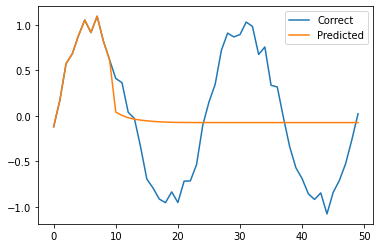

Epoch:11/101 Error:3.1602753794443483


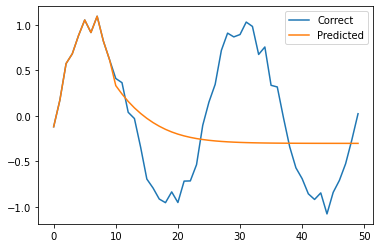

Epoch:21/101 Error:2.132403813557328


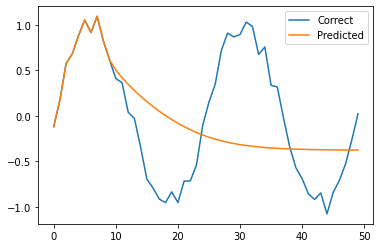

Epoch:31/101 Error:1.5392301501743688


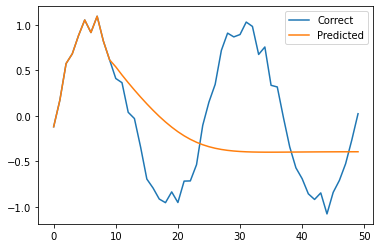

Epoch:41/101 Error:1.02381188027131


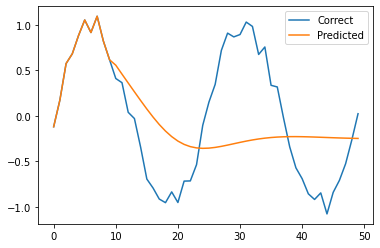

Epoch:51/101 Error:0.6187614411474622


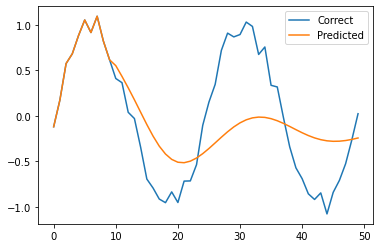

Epoch:61/101 Error:0.3755624126396273


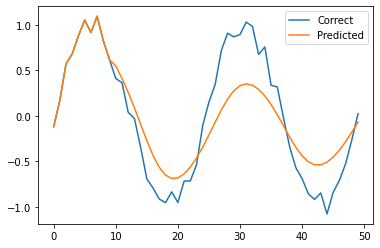

Epoch:71/101 Error:0.2713722124045762


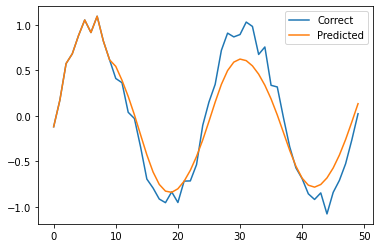

Epoch:81/101 Error:0.23676712732767471


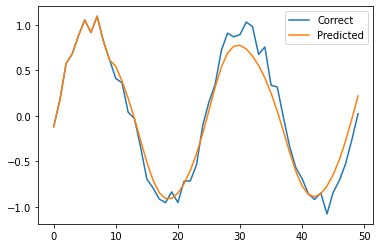

Epoch:91/101 Error:0.22654116137928454


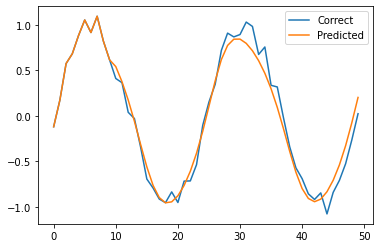

Epoch:101/101 Error:0.22280828377979278


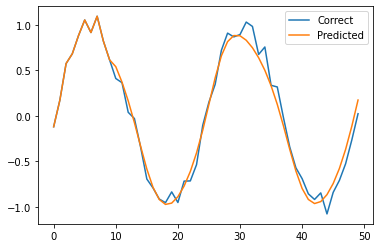

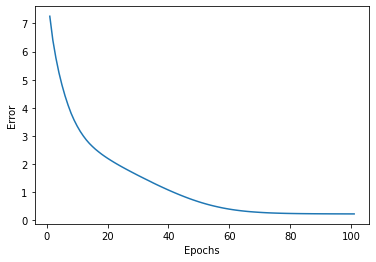

In [8]:
error_record = []
n_batch = len(input_data) // batch_size
for i in range(epochs):
    
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j * batch_size:(j + 1) * batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
    
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    if i % interval == 0:
        print("Epoch:" + str(i + 1) + "/" + str(epochs), "Error:" + str(error))
        
        predicted = input_data[0].reshape(-1).tolist()
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        
plt.plot(range(1, epochs + 1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### Text Generation

In [9]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt

In [10]:
n_time = 20
n_mid = 128

eta = 0.01
clip_const = 0.02
beta = 2 # probability distribution adjustment constant
epochs = 50
batch_size = 128

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
def clip_grad(grads, max_norm):
    norm = np.sqrt(np.sum(grads * grads))
    r = max_norm / norm
    if r < 1:
        clipped_grads = grads * r
    else:
        clipped_grads = grads
    return clipped_grads

In [13]:
# load training data
with open("data/lstm_text/human_problem.txt", mode="r", encoding="utf-8-sig") as f:
    text = f.read()
print("# of characters:", len(text))

# of characters: 60322


In [14]:
chars_list = sorted(list(set(text)))
n_chars = len(chars_list)
print("# of characters without duplication:", n_chars)

# integar encoding
char_to_index = {}
index_to_char = {}
for i, char in enumerate(chars_list):
    char_to_index[char] = i
    index_to_char[i] = char

# of characters without duplication: 980


In [15]:
# make time series data
seq_chars = []
next_chars = []
for i in range(len(text) - n_time):
    seq_chars.append(text[i:i + n_time])
    next_chars.append(text[i + n_time])

# one-hot encoding input and correct
input_data = np.zeros((len(seq_chars), n_time, n_chars), dtype=np.bool_)
correct_data = np.zeros((len(seq_chars), n_chars), dtype=np.bool_)
for i, chars in enumerate(seq_chars):
    correct_data[i, char_to_index[next_chars[i]]] = 1
    for j, char in enumerate(chars):
        input_data[i, j, char_to_index[char]] = 1

In [61]:
class LSTMLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n) # Xavier init
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))
        
    def forward(self, x, y_prev, c_prev):
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)
        
        a0 = sigmoid(u[0])
        a1 = sigmoid(u[1])
        a2 = np.tanh(u[2])
        a3 = sigmoid(u[3])
        self.gates = np.stack((a0, a1, a2, a3))
        
        self.c = a0 * c_prev + a1 * a2
        self.y = a3 * np.tanh(self.c)
        
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + grad_y * a3 * (1 - tanh_c ** 2)
        
        delta0 = r * c_prev * a0 * (1 - a0)
        delta1 = r * a2 * a1 * (1 - a1)
        delta2 = r * a1 * (1 - a2 ** 2)
        delta3 = grad_y * tanh_c * a3 * (1 - a3)
        
        deltas = np.stack((delta0, delta1, delta2, delta3))
        
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)
        
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)
        
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        self.grad_c_prev = r * a0
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b
        
    def clip_grads(self, clip_const):
        self.grad_w = clip_grad(self.grad_w, clip_const * np.sqrt(self.grad_w.size))
        self.grad_v = clip_grad(self.grad_v, clip_const * np.sqrt(self.grad_v.size))

class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u) / np.sum(np.exp(u), axis=1).reshape(-1, 1) # softmax
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [16]:
lstm_layer = LSTMLayer(n_chars, n_mid)
output_layer = OutputLayer(n_mid, n_chars)

In [17]:
def train(x_mb, t_mb):
    y_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        
        y = lstm_layer.y
        y_rnn[:, i + 1, :] = y
        y_prev = y
        
        c = lstm_layer.c
        c_rnn[:, i + 1, :] = c
        c_prev = c
        
        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates
    
    output_layer.forward(y)
    
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)
    
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i + 1, :]
        c = c_rnn[:, i + 1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :]
        
        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev
    
    lstm_layer.clip_grads(clip_const)
    lstm_layer.update(eta)
    output_layer.update(eta)
    
def predict(x_mb):
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
        
    output_layer.forward(y)
    return output_layer.y

def get_error(x, t):
    limit = 1000
    if len(x) > limit:
        index_random = np.arange(len(x))
        np.random.shuffle(index_random)
        x = x[index_random[:limit], :]
        t = t[index_random[:limit], :]
    y = predict(x)
    return -np.sum(t * np.log(y + 1e-7)) / batch_size # cross_entropy

In [18]:
def create_text():
    prev_text = text[0:n_time]
    created_text = prev_text
    print("Seed:", created_text)
    for i in range(200):
        x = np.zeros((1, n_time, n_chars))
        for j, char in enumerate(prev_text):
            x[0, j, char_to_index[char]] = 1
        
        y = predict(x)
        p = y[0] ** beta # Probability distribution adjustment
        p /= np.sum(p) # Make the sum of p equal to 1
        next_index = np.random.choice(len(p), size=1, p=p) # randomly choose next character
        next_char = index_to_char[int(next_index[0])]
        created_text += next_char
        prev_text = prev_text[1:] + next_char # next input
        
    print(created_text)
    print()

Epoch: 1/50 471/471 Error: 27.05142770186471
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇는 선비의 이 없의 아 있는 것 어머니는 바 같을 말이 나째다.
이서 어머니는 아이 하니 나 말을 바라서 어머니는 아이 나 가어머니.
이 그래 어머니가 선비 어머니 말은 그리고 부어 들어 것을 바라 없어 서 어머니를 것이 선비를 있어서 것을 어머니를 무 같이 못 방은 물이 마어서 아이, 선비는 선비를 들어가 것이 그는 어머니가 그는 것이 소리를 왔다.
덕호

Epoch: 2/50 471/471 Error: 26.303636176767917
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 나고 하고 선비는 생각을 다고 않는 아늘히 하여 보았다. 그리고 자음이 않는다. 
그 어머니는 말을 다시 그는 새지 그는 자시 보았다. 그리고 모어 돌어왔다. 그는 그리고 돌어보며 가는다. 이 해 어머니는 옥점이를 하고 나가 그들은 다 어머니는 자아 가 가는 나서 들어 보고 않는 것을 그 집어 않는 것을 같았다. 그리고 자리를 들었다. 그는 방이 다가 

Epoch: 3/50 471/471 Error: 25.783618829876982
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 하고 않는 것을 다시 못어 들어 다고 다니 뭐 나서 없이 않았다.
그는 얼굴이 없이 그의 무각을 하고 고 없었다.
그는 이 없어 돌아 다고 일어나며 그런 이렇게 하였다.
그러나 어머니 해 선비가 어디 있다.
어머니는 무쨍 소리에 않고 나오는 것이 벌아 가지야 하였다. 
그는 신철이는 말을 바라보며 선비를 하고 나온다.
그러나 어머니 지두 왔다.
이 방에

Epoch: 4/50 471/471 Error: 24.287234359487847
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 나무다리는 것이다. 
그러나 그는 머리

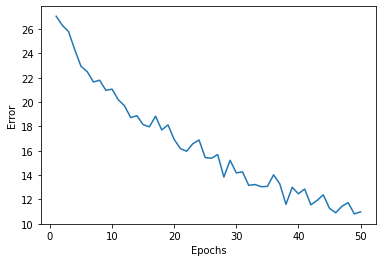

time : 1889.3223855495453


In [47]:
# output for training without clipping gradient


Epoch: 1/50 471/471 Error: 31.57175092715376
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇 바이 사이 은 일게 것지 가 이을 가 이 말어다.
그는 하을 마어 없다. 나가 하보을 그고 가 가 어쎄 내을 그어지 말을 기가 이 들고 말 그을 가 끊이 길로 내니는 하었이 가 기 집로 보여을 사을 가 하은 신이 하의 생이 저을 이 하고 하을 어리을 하을 바고 선가 오을 보가 그을 이어 아이 보는 바는 일, 바었다.
그이 그리는 무니 어리고 무라방을 슨에

Epoch: 2/50 471/471 Error: 28.02530699582612
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇 생각을 ! 같어 첫 것이 말라이 과 놀이 들을 하고 주 자을 않이 눈하다. 그서 어리는 말이 것을 나다.

그리 바며 어아가 어지 않 그는 고 바라가 가 들은 소라 어니다.
이 그리고 나 어들을 나 이 들어 보리 나지 그리 아지 이 사고 하가 하는 다.
그는 자 사이 주지 발 소고 자리 동 내다. 그리고 그 아이 어라가 나 않어 일고 것을 바라가 들어 이

Epoch: 3/50 471/471 Error: 27.023827524075422
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 하고 어머니는 이서 아을 하며 그하였다.
이서 사밴이는 그의 생을 하였다. 그리고 것을 가 일어서 선비는 웬지를 모로 아니는 것을 보았다.
그는 가라지 어머니는 들이다.
그는 사리고 어머니 어머니는 선비는 길을 이는 주에가 그의 어머니는 선비가 선비는 들어가 하고 것을 하였다.
그리고 것을 한 하고 바았다.
그호는 일어머니는 빨우니 아무다.
이게 어머니

Epoch: 4/50 471/471 Error: 25.378314381161594
Seed: 이 산등에 올라서면 용연 동네는 저렇
이 산등에 올라서면 용연 동네는 저렇게 어머니 어머니는 하는 말이 하고 어서 어

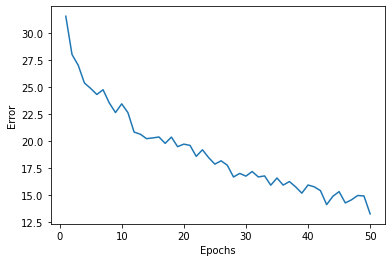

time : 1928.7747883796692


In [64]:
# training with clipping gradient
import time
start = time.time()

error_record = []
n_batch = len(input_data) // batch_size
for i in range(epochs):
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j * batch_size:(j + 1) * batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
        
        print("\rEpoch: " + str(i + 1) + "/" + str(epochs) + \
              " " + str(j + 1) + "/" + str(n_batch), end="")
    error = get_error(input_data, correct_data)
    error_record.append(error)
    print(" Error: " + str(error))
    
    create_text()
    
plt.plot(range(1, len(error_record) + 1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

print("time :", time.time() - start)